# Leaf Disease Classification Pytorch Pipeline
> A simple image classification pipeline for beginner 

* toc: true
* badges: true
* comments: true

In [1]:
# importing the libraries
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import os 
from pathlib import Path
import json
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np 
from tqdm import tqdm
import pandas as pd 
import torchvision
import time

# Directory Setup

In [2]:
# All given filess

path = Path("../input/cassava-leaf-disease-classification")
os.listdir(path)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [3]:
# Labeled Class File

file = open(os.path.join(path, 'label_num_to_disease_map.json'))
class_map = json.load(file)
class_map

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [4]:
# dataset

df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [5]:
# Count of Each Class 

df['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

# Config

In [6]:
lr = 0.01
bs = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10

# Kfold 

Since dataset is imbalance therefore we will use StratifiedKFold

In [7]:
# K fold

from sklearn.model_selection import StratifiedKFold

df['kfold'] = -1

df = df.sample(frac=1).reset_index(drop=True)

y = df['label'].values

kf = StratifiedKFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X = df, y = y)):
    df.loc[v_, 'kfold'] = f
    
df.to_csv('train_folds.csv', index=False)

In [8]:
train_df = pd.read_csv('train_folds.csv')
print(train_df.shape)
train_df.head()

(21397, 3)


,image_id,label,kfold
0,1290835464.jpg,4,0
1,4145817013.jpg,1,0
2,860826658.jpg,3,0
3,3152107203.jpg,3,0
4,1871120832.jpg,3,0


In [9]:
# Lets look at one fold and number of all Classes

df.loc[df.kfold==0]['label'].value_counts()

3    2631
4     516
2     477
1     438
0     218
Name: label, dtype: int64

# Transform

In [10]:
train_tfms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
valid_tfms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),])

# Dataset and DataLoader

In [11]:
# Dataset and Dataloader

class LeafDataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.df = df 
        self.root = root
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name, label, _ = self.df.iloc[int(idx)]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)
        
        return img, torch.tensor(label)

In [12]:
train_dir = os.path.join(path, "train_images")

fold = 0
df_train = train_df[train_df.kfold==fold]
vdf_valid = train_df[train_df.kfold!=fold]

# dataset
train_ds = LeafDataset(train_df, root=train_dir, transform=train_tfms)
train_dl = DataLoader(train_ds, batch_size = bs, shuffle=True)

# Visualize Data

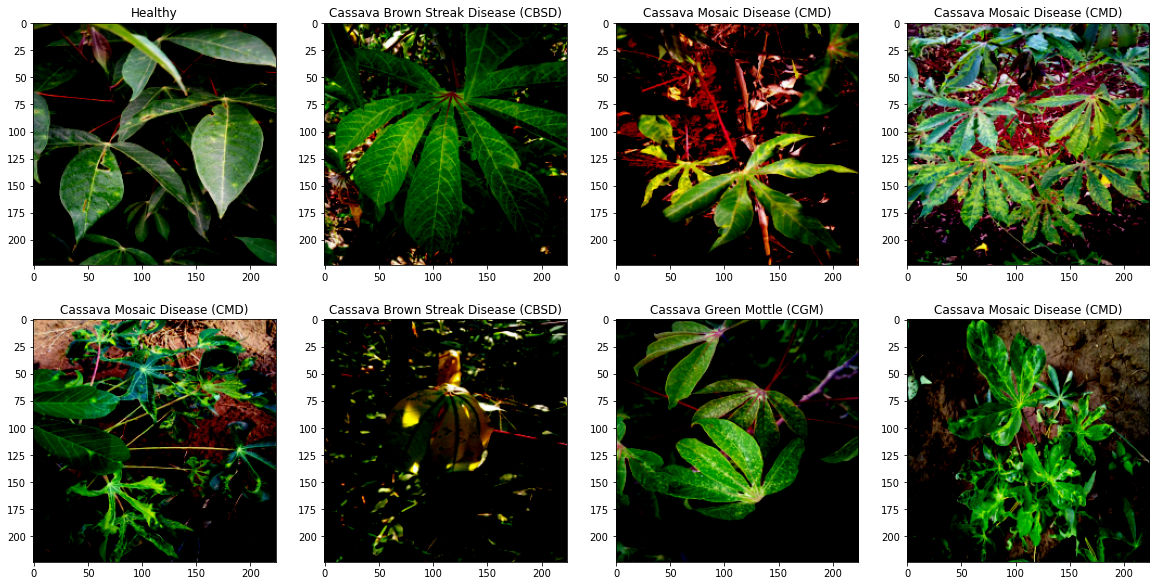

In [13]:
plt.figure(figsize=(20,10))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = train_ds[i][0]
    label = train_ds[i][1]
    plt.title(class_map[str(label.item())])
    plt.imshow(img.permute(1,2,0))

# Model

In [14]:
model = torchvision.models.resnet34(pretrained=True)
model.fc = nn.Linear(512, 5)

class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = torchvision.models.resnet34(pretrained=True)
        else:
            self.model = torchvision.models.resnet34()
        # change the classification layer
        self.l0= nn.Linear(1000, 5)
        self.dropout = nn.Dropout2d(0.4)
        
    def forward(self, x):
        batch = x.shape[0]
        x = self.model(x)
        l0 = self.l0(x)
        out = nn.Softmax(dim=1)(l0)
        return out

model = ResNet34(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# Testing on one batch

In [15]:
from sklearn.metrics import accuracy_score

xb, yb = next(iter(train_dl))

xb = xb.to(device)
yb = yb.to(device)

output = model(xb)

loss_fn = nn.CrossEntropyLoss()

print('output shape', output.shape)

loss = loss_fn(output, yb)

print('loss', loss.detach().cpu().numpy())

prediction = torch.argmax(output, dim=1)

accuracy = accuracy_score(yb.cpu().numpy(), prediction.cpu().numpy())

print('accuracy', accuracy*100)

output shape torch.Size([32, 5])
loss 1.6175209
accuracy 12.5


# Training Function

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [17]:
def Validation(dl):
    losses, accuracy = [], []
    with torch.no_grad():
        for data in tqdm(dl):
            xb, yb = data[0].to(device), data[1].to(device)
            output = model(xb)
            loss = loss_fn(output, yb)
            prediction = torch.argmax(output, dim=1)
            acc = accuracy_score(yb.cpu().numpy(), prediction.cpu().numpy())
            losses.append(loss.item())
            accuracy.append(acc)
    return sum(losses)/len(losses), sum(accuracy)/len(accuracy)

In [18]:
def train(model, train_dl,valid_dl, optimizer):
    
    train_acc, train_loss = [], []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm(train_dl)):

            xb, yb = data[0].to(device), data[1].to(device)


            optimizer.zero_grad()

            output = model(xb)

            loss = loss_fn(output, yb)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        val_loss, val_acc = Validation(valid_dl)
        print('Epoch: %d, Train Loss: %0.3f, Val Loss: %0.3f, Val Acc: %0.3f'% (epoch, running_loss/len(train_dl), val_loss, val_acc))

# Testing 

In [19]:
train_dir = os.path.join(path, "train_images")
train_df = pd.read_csv('train_folds.csv')

fold = 0
df_train = train_df[train_df.kfold!=fold]
df_valid = train_df[train_df.kfold==fold]

# dataset
train_ds = LeafDataset(df_train, root=train_dir, transform=train_tfms)
valid_ds = LeafDataset(df_valid, root=train_dir,  transform=valid_tfms)

# Subset of Dataset
train_ds = Subset(train_ds, np.arange(len(train_ds)/10))
valid_ds = Subset(valid_ds, np.arange(len(train_ds)/10))

# dataloader
train_dl = DataLoader(train_ds, batch_size = bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size = bs, shuffle=False)

# Train 
print('------------Fold: %d-----------------'%(fold))
tik = time.time()
train(model,train_dl,valid_dl, optimizer)
tok = time.time()
print('total time taken: %0.2f' % ((tok-tik)/60))

------------Fold: 0-----------------


100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


Epoch: 0, Train Loss: 1.293, Val Loss: 1.264, Val Acc: 0.630


100%|██████████| 6/6 [00:02<00:00,  2.49it/s]


Epoch: 1, Train Loss: 1.206, Val Loss: 1.233, Val Acc: 0.677


100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


Epoch: 2, Train Loss: 1.141, Val Loss: 1.221, Val Acc: 0.693


100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


Epoch: 3, Train Loss: 1.101, Val Loss: 1.201, Val Acc: 0.722


100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


Epoch: 4, Train Loss: 1.072, Val Loss: 1.210, Val Acc: 0.693


100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


Epoch: 5, Train Loss: 1.051, Val Loss: 1.216, Val Acc: 0.693


100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch: 6, Train Loss: 1.037, Val Loss: 1.225, Val Acc: 0.688


100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch: 7, Train Loss: 1.020, Val Loss: 1.232, Val Acc: 0.672


100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


Epoch: 8, Train Loss: 0.996, Val Loss: 1.229, Val Acc: 0.681


100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

Epoch: 9, Train Loss: 0.978, Val Loss: 1.237, Val Acc: 0.642
total time taken: 5.39


# First We will Train on a Subset of Dataset

In [20]:
# train_dir = os.path.join(path, "train_images")
# train_df = pd.read_csv('train_folds.csv')

# for fold in range(5):

#     df_train = train_df[train_df.kfold==fold]
#     df_valid = train_df[train_df.kfold!=fold]

#     # dataset
#     train_ds = LeafDataset(train_df, root=train_dir, transform=tfms)
#     valid_ds = LeafDataset(df_valid, root=train_dir,  transform=tfms)

#     # Subset of Dataset
#     train_ds = Subset(train_ds, np.arange(len(train_ds)/4))
#     valid_ds = Subset(valid_ds, np.arange(len(train_ds)/4))

#     # dataloader
#     train_dl = DataLoader(train_ds, batch_size = bs, shuffle=True)
#     valid_dl = DataLoader(valid_ds, batch_size = bs, shuffle=False)

#     # Train 
#     print('------------Fold: %d-----------------'%(fold))
#     train(model,train_dl,valid_dl, optimizer)

# Lets Train On Half of The Dataset

In [21]:
# train_dir = os.path.join(path, "train_images")
# train_df = pd.read_csv('train_folds.csv')

# for fold in range(5):

#     df_train = train_df[train_df.kfold!=fold]
#     df_valid = train_df[train_df.kfold==fold]
    

#     # dataset
#     train_ds = LeafDataset(df_train, root=train_dir, transform=train_tfms)
#     valid_ds = LeafDataset(df_valid, root=train_dir,  transform=valid_tfms)

#     # Subset of Dataset
#     train_ds = Subset(train_ds, np.arange(len(train_ds)/2))
#     valid_ds = Subset(valid_ds, np.arange(len(valid_ds)/2))

#     # dataloader
#     train_dl = DataLoader(train_ds, batch_size = bs, shuffle=True)
#     valid_dl = DataLoader(valid_ds, batch_size = bs, shuffle=False)
#     print(len(train_dl), len(valid_dl))
    
#     # Train 
#     print('------------Fold: %d-----------------'%(fold))
#     tik = time.time()
#     train(model,train_dl,valid_dl, optimizer)
#     tok = time.time()
#     print('total time taken: %0.2f' % ((tok-tik)/60))

In [22]:
train_dir = os.path.join(path, "train_images")
train_df = pd.read_csv('train_folds.csv')

for fold in range(5):

    df_train = train_df[train_df.kfold!=fold]
    df_valid = train_df[train_df.kfold==fold]
    

    # dataset
    train_ds = LeafDataset(df_train, root=train_dir, transform=train_tfms)
    valid_ds = LeafDataset(df_valid, root=train_dir,  transform=valid_tfms)
    # Subset of Dataset
    train_ds = Subset(train_ds, np.arange(len(train_ds)))
    valid_ds = Subset(valid_ds, np.arange(len(valid_ds)))

    # dataloader
    train_dl = DataLoader(train_ds, batch_size = bs, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size = bs, shuffle=False)
    
    # Train 
    print('------------Fold: %d-----------------'%(fold))
    tik = time.time()
    train(model,train_dl,valid_dl, optimizer)
    tok = time.time()
    print('total time taken: %0.2f' % ((tok-tik)/60))

------------Fold: 0-----------------


100%|██████████| 134/134 [01:30<00:00,  1.47it/s]


Epoch: 0, Train Loss: 1.149, Val Loss: 1.146, Val Acc: 0.752


100%|██████████| 134/134 [01:02<00:00,  2.13it/s]


Epoch: 1, Train Loss: 1.085, Val Loss: 1.125, Val Acc: 0.776


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 2, Train Loss: 1.049, Val Loss: 1.116, Val Acc: 0.785


100%|██████████| 134/134 [01:02<00:00,  2.15it/s]


Epoch: 3, Train Loss: 1.023, Val Loss: 1.119, Val Acc: 0.781


100%|██████████| 134/134 [01:02<00:00,  2.16it/s]


Epoch: 4, Train Loss: 1.005, Val Loss: 1.117, Val Acc: 0.787


100%|██████████| 134/134 [01:02<00:00,  2.13it/s]


Epoch: 5, Train Loss: 0.989, Val Loss: 1.111, Val Acc: 0.793


100%|██████████| 134/134 [01:03<00:00,  2.10it/s]


Epoch: 6, Train Loss: 0.979, Val Loss: 1.116, Val Acc: 0.784


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 7, Train Loss: 0.970, Val Loss: 1.114, Val Acc: 0.788


100%|██████████| 134/134 [01:01<00:00,  2.19it/s]


Epoch: 8, Train Loss: 0.963, Val Loss: 1.109, Val Acc: 0.791


100%|██████████| 134/134 [01:01<00:00,  2.19it/s]


Epoch: 9, Train Loss: 0.962, Val Loss: 1.114, Val Acc: 0.788
total time taken: 60.10
------------Fold: 1-----------------


100%|██████████| 134/134 [01:00<00:00,  2.20it/s]


Epoch: 0, Train Loss: 0.999, Val Loss: 0.977, Val Acc: 0.929


100%|██████████| 134/134 [01:00<00:00,  2.21it/s]


Epoch: 1, Train Loss: 0.986, Val Loss: 0.979, Val Acc: 0.926


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 2, Train Loss: 0.974, Val Loss: 0.982, Val Acc: 0.925


100%|██████████| 134/134 [01:01<00:00,  2.19it/s]


Epoch: 3, Train Loss: 0.967, Val Loss: 0.989, Val Acc: 0.916


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 4, Train Loss: 0.963, Val Loss: 0.981, Val Acc: 0.923


100%|██████████| 134/134 [01:02<00:00,  2.16it/s]


Epoch: 5, Train Loss: 0.959, Val Loss: 0.984, Val Acc: 0.922


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 6, Train Loss: 0.954, Val Loss: 0.984, Val Acc: 0.922


100%|██████████| 134/134 [01:00<00:00,  2.22it/s]


Epoch: 7, Train Loss: 0.952, Val Loss: 0.987, Val Acc: 0.919


100%|██████████| 134/134 [01:00<00:00,  2.20it/s]


Epoch: 8, Train Loss: 0.949, Val Loss: 0.988, Val Acc: 0.918


100%|██████████| 134/134 [01:00<00:00,  2.22it/s]


Epoch: 9, Train Loss: 0.948, Val Loss: 0.985, Val Acc: 0.921
total time taken: 57.08
------------Fold: 2-----------------


100%|██████████| 134/134 [01:00<00:00,  2.21it/s]


Epoch: 0, Train Loss: 0.954, Val Loss: 0.955, Val Acc: 0.952


100%|██████████| 134/134 [01:00<00:00,  2.20it/s]


Epoch: 1, Train Loss: 0.950, Val Loss: 0.956, Val Acc: 0.949


100%|██████████| 134/134 [01:00<00:00,  2.21it/s]


Epoch: 2, Train Loss: 0.946, Val Loss: 0.954, Val Acc: 0.952


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 3, Train Loss: 0.943, Val Loss: 0.955, Val Acc: 0.951


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 4, Train Loss: 0.942, Val Loss: 0.956, Val Acc: 0.949


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 5, Train Loss: 0.940, Val Loss: 0.956, Val Acc: 0.950


100%|██████████| 134/134 [01:02<00:00,  2.16it/s]


Epoch: 6, Train Loss: 0.939, Val Loss: 0.956, Val Acc: 0.949


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 7, Train Loss: 0.938, Val Loss: 0.955, Val Acc: 0.949


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 8, Train Loss: 0.938, Val Loss: 0.956, Val Acc: 0.949


100%|██████████| 134/134 [01:02<00:00,  2.16it/s]


Epoch: 9, Train Loss: 0.936, Val Loss: 0.956, Val Acc: 0.949
total time taken: 56.91
------------Fold: 3-----------------


100%|██████████| 134/134 [01:01<00:00,  2.16it/s]


Epoch: 0, Train Loss: 0.940, Val Loss: 0.941, Val Acc: 0.963


100%|██████████| 134/134 [01:00<00:00,  2.20it/s]


Epoch: 1, Train Loss: 0.938, Val Loss: 0.941, Val Acc: 0.965


100%|██████████| 134/134 [00:59<00:00,  2.24it/s]


Epoch: 2, Train Loss: 0.937, Val Loss: 0.943, Val Acc: 0.962


100%|██████████| 134/134 [01:01<00:00,  2.17it/s]


Epoch: 3, Train Loss: 0.936, Val Loss: 0.942, Val Acc: 0.964


100%|██████████| 134/134 [01:02<00:00,  2.16it/s]


Epoch: 4, Train Loss: 0.936, Val Loss: 0.941, Val Acc: 0.964


100%|██████████| 134/134 [01:00<00:00,  2.22it/s]


Epoch: 5, Train Loss: 0.935, Val Loss: 0.941, Val Acc: 0.963


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 6, Train Loss: 0.934, Val Loss: 0.943, Val Acc: 0.962


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 7, Train Loss: 0.934, Val Loss: 0.944, Val Acc: 0.961


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 8, Train Loss: 0.934, Val Loss: 0.943, Val Acc: 0.962


100%|██████████| 134/134 [00:59<00:00,  2.23it/s]


Epoch: 9, Train Loss: 0.933, Val Loss: 0.943, Val Acc: 0.962
total time taken: 57.24
------------Fold: 4-----------------


100%|██████████| 134/134 [01:02<00:00,  2.14it/s]


Epoch: 0, Train Loss: 0.934, Val Loss: 0.934, Val Acc: 0.971


100%|██████████| 134/134 [01:02<00:00,  2.14it/s]


Epoch: 1, Train Loss: 0.934, Val Loss: 0.935, Val Acc: 0.970


100%|██████████| 134/134 [01:01<00:00,  2.17it/s]


Epoch: 2, Train Loss: 0.933, Val Loss: 0.935, Val Acc: 0.969


100%|██████████| 134/134 [01:00<00:00,  2.20it/s]


Epoch: 3, Train Loss: 0.933, Val Loss: 0.935, Val Acc: 0.970


100%|██████████| 134/134 [01:01<00:00,  2.18it/s]


Epoch: 4, Train Loss: 0.933, Val Loss: 0.936, Val Acc: 0.969


100%|██████████| 134/134 [01:03<00:00,  2.12it/s]


Epoch: 5, Train Loss: 0.932, Val Loss: 0.936, Val Acc: 0.969


100%|██████████| 134/134 [01:02<00:00,  2.13it/s]


Epoch: 6, Train Loss: 0.932, Val Loss: 0.937, Val Acc: 0.968


100%|██████████| 134/134 [01:03<00:00,  2.11it/s]


Epoch: 7, Train Loss: 0.932, Val Loss: 0.936, Val Acc: 0.969


100%|██████████| 134/134 [01:03<00:00,  2.12it/s]


Epoch: 8, Train Loss: 0.932, Val Loss: 0.936, Val Acc: 0.969


100%|██████████| 134/134 [01:02<00:00,  2.16it/s]

Epoch: 9, Train Loss: 0.931, Val Loss: 0.936, Val Acc: 0.969
total time taken: 58.15


In [23]:
# saving the model 
torch.save(model.state_dict(), 'model.pkl')

To improve this model, we have to experiment with different parameters, and we will use wandb to track all the expeeriment, in the next version.

We will make a submission from this model